In [1]:
method = "pretrain"     # pretrain or finetune
isolates = [3, 7]
chromosome = "6"
pval_thresh = 1e-5
part = "top"            # top, low
k_reads = 4000          # 1000, 4000

In [2]:
import torch

import umap
import numpy as np
import pandas as pd
import scipy.stats
import sklearn.decomposition

import os
import seaborn as sns
import tqdm.notebook as tqdm
import matplotlib.pyplot as plt
import matplotlib.patches

""" profile / runs """

# dataset
profile = pd.read_csv("data/stanford/profile.txt")
# Isolate string (i.e. su001) -> int (i.e. 1)
profile["Isolate"] = profile["Isolate"].apply(lambda x: int(x[2:]))
# Treatment pre/post -> 0/1
profile["Treatment"] = profile["Treatment"].apply(lambda x: int(not "pre" in x))
# Sort by Isolate (1 to 8), Treatment (pre to post), and Tissue (normal to BCC)
profile = profile.sort_values(
    by=["Isolate", "Treatment", "Tissue"], ascending=[True, True, False]
).reset_index(drop=True)
# only keep run, isolate, treatment, tissue
profile = profile[["Run", "Isolate", "Treatment", "Tissue"]]

runs = []
for isolate in isolates:
    runs += profile[profile["Isolate"] == isolate]["Run"].to_list()

for run in runs:
    print(profile[profile["Run"] == run].values[0])

""" function """

def euclideanDistance(x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
    x1norm = np.sum(x1**2, axis=1, keepdims=True)           # (N1,  1)
    x2norm = np.sum(x2**2, axis=1, keepdims=True).T         # ( 1, N2)
    x1x2   = 2 * np.dot(x1, x2.T)                           # (N1, N2)
    return np.sqrt(np.maximum(0, x1norm + x2norm - x1x2))   # (N1, N2)

def pearsonCorrelation(x1: np.ndarray, x2: np.ndarray) -> np.ndarray:
    x1centered = x1 - x1.mean(axis=1, keepdims=True)        # (N1, 768)
    x2centered = x2 - x2.mean(axis=1, keepdims=True)        # (N2, 768)
    numerator = np.dot(x1centered, x2centered.T)            # (N1, N2)
    x1var = np.sum(x1centered**2, axis=1, keepdims=True)    # (N1,  1)
    x2var = np.sum(x2centered**2, axis=1, keepdims=True)    # (N2,  1)
    denominator = np.sqrt(np.dot(x1var, x2var.T))           # (N1, N2)
    return numerator / denominator                          # (N1, N2)

['SRR8924597' 3 0 'normal skin']
['SRR8924599' 3 0 'BCC tumor']
['SRR8924596' 3 1 'BCC tumor']
['SRR8924586' 7 0 'normal skin']
['SRR8924580' 7 0 'BCC tumor']
['SRR8924581' 7 1 'BCC tumor']


In [3]:
""" embd: {run: (N, 776)} after filter """

embd = {}
for run in runs:
    embd[run] = np.load(f"data/stanford/embd-{method}/{run}/{chromosome}.npy")
    embd[run] = embd[run][embd[run][:, 769-int(np.log10(pval_thresh))]>=1, :]

# get filter of reads of each sample by Euclidean distance matrix
filter = [[
    np.full(len(embd[runs[i]]), False, dtype=bool) for _ in range(len(runs))
] for i in range(len(runs))]
for i in range(len(runs)):
    for j in range(i+1, len(runs)):
        x1embd = embd[runs[i]][:, :768]                         # (Ni, 768)
        x2embd = embd[runs[j]][:, :768]                         # (Nj, 768)
        x1pos  = embd[runs[i]][:,  768]                         # (Ni, )
        x2pos  = embd[runs[j]][:,  768]                         # (Nj, )

        distance_matrix = euclideanDistance(x1embd, x2embd)     # (Ni, Nj)

        # concate into DataFrame to keep track index
        x1df = pd.DataFrame(
            {"distance": np.max(distance_matrix, axis=1), "pos": x1pos}
        )
        x2df = pd.DataFrame(
            {"distance": np.max(distance_matrix, axis=0), "pos": x2pos}
        )

        if part == "top":   # sort from distance high to low
            x1df = x1df.sort_values(by="distance", ascending=False)
            x2df = x2df.sort_values(by="distance", ascending=False)
        if part == "low":   # sort from distance low to high
            x1df = x1df.sort_values(by="distance", ascending=True)
            x2df = x2df.sort_values(by="distance", ascending=True)

        # drop duplicates reads with same position
        x1df = x1df.drop_duplicates(subset="pos", keep="first")
        x2df = x2df.drop_duplicates(subset="pos", keep="first")

        # keep k_reads of head, get there index that match original embd, 
        # transfer index to one hot filter
        filter[i][j][x1df.head(k_reads).index] = True           # (Ni, )
        filter[j][i][x2df.head(k_reads).index] = True           # (Nj, )
filter = {runs[i]: np.any(filter[i], axis=0) for i in range(len(runs))}

# apply filter, only keep reads that True in filter
embd = {run: embd[run][filter[run]] for run in runs}    # {run: (N, 776)}

In [4]:
# pca: {run: (N, 5)}
pca_reducer = sklearn.decomposition.PCA(n_components=5)
pca_reducer.fit(np.concatenate([embd[run][:, :768] for run in runs], axis=0))
pca = {run: pca_reducer.transform(embd[run][:, :768]) for run in runs}
# umap: {run: (N, 2)}
umap_reducer = umap.UMAP(n_components=2)
umap_reducer.fit(np.concatenate([embd[run][:, :768] for run in runs], axis=0))
umap = {run: umap_reducer.transform(embd[run][:, :768]) for run in runs}
# pos: {run: (N, 1)}
pos = {run: embd[run][:, 768] for run in runs}

/home/s.tianrui.qi/miniconda3/envs/TCGA-Onc/lib/python3.10/site-packages/scipy/sparse/_index.py:145: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [14]:
# get unique pos of all selected reads of all samples
pos_all = np.sort(np.unique(np.concatenate([pos[run] for run in runs])))
pos_all = pd.DataFrame(index=pos_all)
for run in runs:
    pos_all[run] = np.zeros(len(pos_all))
    pos_all.loc[pos[run], run] = pca[run][:, 0]

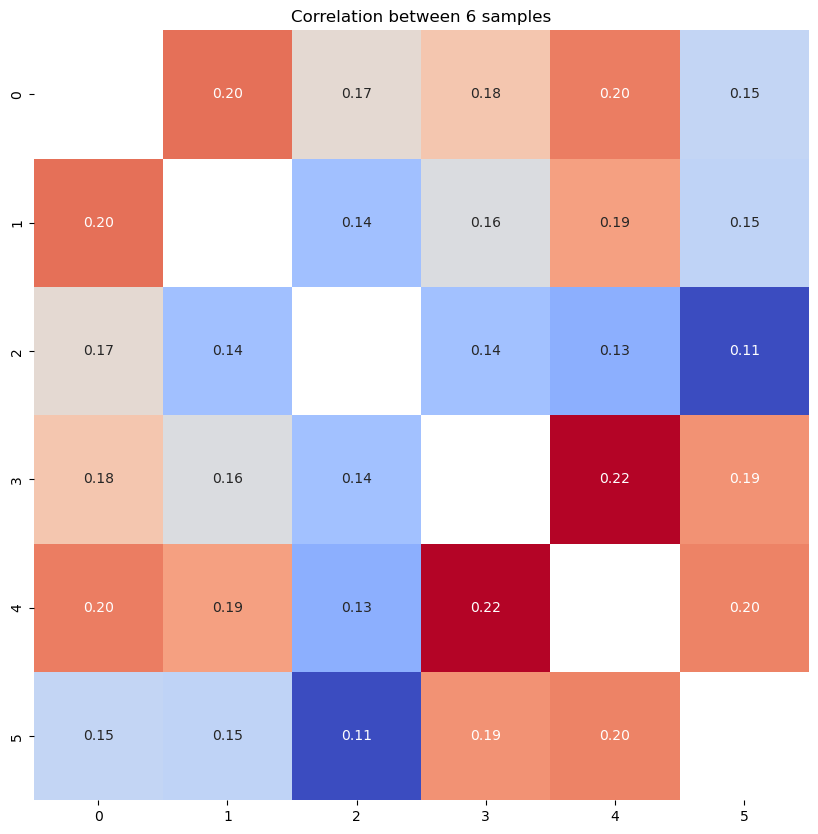

In [15]:
heat_map = np.nan * np.zeros((len(runs), len(runs)))
for i in range(len(runs)):
    for j in range(i+1, len(runs)):
        x1 = pos_all[runs[i]].values.reshape(-1, 1).T
        x2 = pos_all[runs[j]].values.reshape(-1, 1).T
        corr = pearsonCorrelation(x1, x2)
        heat_map[i, j] = corr[0, 0]
        heat_map[j, i] = corr[0, 0]
# plot the heat map 6*6 
plt.figure(figsize=(10, 10))
sns.heatmap(heat_map, annot=True, fmt=".2f", cmap="coolwarm", cbar=False)
plt.title(f"Correlation between {len(runs)} samples")
plt.show()

In [ ]:
""" Plot Distribution of Euclidean Distance """

bins = 100
fontsize = 18

x1embd, x2embd = embd[runs[0]], embd[runs[1]]   # (N1, 768), (N2, 768)
distance_matrix = euclideanDistance(x1embd, x2embd)     # (N1, N2)
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
for i in range(2):
    axs[i].hist(np.max(distance_matrix, axis=int(not i)), bins=bins)
    # title
    id, isolate, treatment, tissue = profile[profile["Run"] == runs[i]].iloc[0]
    treatment = "Pre" if treatment == 0 else "Post"
    tissue = "Normal" if "normal" in tissue else "Tumor"
    info = f"{id} - {isolate} - {treatment} - {tissue}"
    axs[i].set_title(f"{info}", fontweight='bold', fontsize=fontsize)
    # axis
    axs[i].set_xlim(5, 11)
fig.supxlabel("Euclidean Distance", fontweight='bold', y=0.004, fontsize=fontsize)
fig.supylabel("Number of Reads", fontweight='bold', x=0.008, fontsize=fontsize)
fig.tight_layout()
fig.show()

In [ ]:
""" Plot Hexbin N * N+1"""

gridsize = 80
vmin, vmax = 4, 64
fontsize = 18

fig, axs = plt.subplots(
    len(runs), len(runs)+1, figsize=(35, 30), 
    sharex=True, sharey=True
)
# plot
for i in range(len(runs)):
    # plot umpa of sample i before filter in diagonal
    axs[i, i].hexbin(
        umap[runs[i]][:, 0], umap[runs[i]][:, 1], 
        cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax,
    )
    # plot umap of (i, :) and (:, i) after filter by distance (i, j)
    for j in range(i+1, len(runs)):
        # umap of (i, :)
        axs[i, j].hexbin(
            umap[runs[i]][:, 0], umap[runs[i]][:, 1], 
            cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax/2,
        )
        # umap of (:, i)
        axs[j, i].hexbin(
            umap[runs[j]][:, 0], umap[runs[j]][:, 1], 
            cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax/2,
        )
    # plot umap of (i, len(runs)) of combine all filter
    axs[i, len(runs)].hexbin(
        umap[runs[i]][:, 0], 
        umap[runs[i]][:, 1], 
        cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax/2,
    )
# set up axis and label
for i in range(len(runs)):
    id, isolate, treatment, tissue = profile[profile["Run"] == runs[i]].iloc[0]
    treatment = "Pre" if treatment == 0 else "Post"
    tissue = "Normal" if "normal" in tissue else "Tumor"
    info = f"{id} - {isolate} - {treatment} - {tissue}"
    axs[0,  i].set_xlabel(info, fontsize=fontsize, fontweight='bold')
    axs[0,  i].xaxis.set_label_position("top")
    axs[0, len(runs)].set_xlabel("All Selected Reads", fontsize=fontsize, fontweight='bold')
    axs[0, len(runs)].xaxis.set_label_position("top")
    axs[i, -1].set_ylabel(info, fontsize=fontsize, fontweight='bold')
    axs[i, -1].yaxis.set_label_position("right")
    for j in range(len(runs)+1):
        axs[i, j].set_aspect("equal")
        axs[i, j].set_xlim(-22, 22)
        axs[i, j].set_ylim(-22, 22)
fig.supxlabel("UMAP1", fontsize=fontsize, fontweight='bold', y=0.004)
fig.supylabel("UMAP2", fontsize=fontsize, fontweight='bold', x=0.008)
fig.tight_layout()
fig.savefig("temp.png", dpi=500)
fig.show()

In [ ]:
""" Plot Scatter of all samples """

s=0.4

fig, axs = plt.subplots(1, 3, figsize=(30, 10), sharex=True, sharey=True)
# scatter, color by run
for i in range(len(runs)):
    axs[0].scatter(
        umap[runs[i]][:, 0], 
        umap[runs[i]][:, 1], 
        label=f"{runs[i]}", s=0.5
    )
axs[0].set_xlim(-22, 22)
axs[0].set_ylim(-22, 22)
axs[0].legend()
# scatter, color by isolate
for i in range(len(runs)):
    axs[1].scatter(
        umap[runs[i]][:, 0], 
        umap[runs[i]][:, 1], 
        c="red" if profile[profile["Run"] == runs[i]]["Isolate"].values[0] == 3 else "blue",
        label="su00{}".format(profile[profile["Run"] == runs[i]]["Isolate"].values[0]),
        s=s
    )
axs[1].set_xlim(-22, 22)
axs[1].set_ylim(-22, 22)
axs[1].legend(
    handles=[
        matplotlib.patches.Patch(color="r", label="su003"), 
        matplotlib.patches.Patch(color="b", label="su007")
    ], loc="upper right", ncol=1, fontsize=14,
)
# scatter, color by treatment
for i in range(len(runs)):
    axs[2].scatter(
        umap[runs[i]][:, 0], 
        umap[runs[i]][:, 1], 
        c="red" if profile[profile["Run"] == runs[i]]["Treatment"].values[0] == 0 else "blue",
        label="Pre" if profile[profile["Run"] == runs[i]]["Treatment"].values[0] == 0 else "Post",
        s=s
    )
axs[2].set_xlim(-22, 22)
axs[2].set_ylim(-22, 22)
axs[2].legend(
    handles=[
        matplotlib.patches.Patch(color="r", label="pre "), 
        matplotlib.patches.Patch(color="b", label="post")
    ], loc="upper right", ncol=1, fontsize=14,
)
fig.tight_layout()
fig.show()

In [ ]:
""" Plot Hexbin of all samples """

gridsize = 80
vmin, vmax = 4, 64
fontsize = 18

# hexbin, split by isolate
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
umap_isolates = [None, None]
for i in range(len(runs)):
    axs_index = 0 if profile[profile["Run"] == runs[i]]["Isolate"].values[0] == 3 else 1
    if umap_isolates[axs_index] is None:
        umap_isolates[axs_index] = umap[runs[i]]
    else:
        umap_isolates[axs_index] = np.concatenate(
            [umap_isolates[axs_index], umap[runs[i]]]
        )
for axs_index in range(2):
    axs[axs_index].hexbin(
        umap_isolates[axs_index][:, 0], umap_isolates[axs_index][:, 1], 
        cmap="Reds", gridsize=gridsize, vmin=vmin, vmax=vmax,
    )
    axs[axs_index].set_xlim(-22, 22)
    axs[axs_index].set_ylim(-22, 22)
    axs[axs_index].set_title(
        "su003" if axs_index == 0 else "su007", 
        fontweight='bold', fontsize=fontsize
    )
fig.tight_layout()
fig.show()

# hexbin, split by treatment
fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=True, sharey=True)
umap_treatments = [None, None]
for i in range(len(runs)):
    axs_index = profile[profile["Run"] == runs[i]]["Treatment"].values[0]
    if umap_treatments[axs_index] is None:
        umap_treatments[axs_index] = umap[runs[i]]
    else:
        umap_treatments[axs_index] = np.concatenate(
            [umap_treatments[axs_index], umap[runs[i]]]
        )
for axs_index in range(2):
    axs[axs_index].hexbin(
        umap_treatments[axs_index][:, 0], umap_treatments[axs_index][:, 1], 
        cmap="Reds", gridsize=gridsize,
        vmin = vmin if axs_index == 0 else (vmin/2),
        vmax = vmax if axs_index == 0 else (vmax/2)
    )
    axs[axs_index].set_xlim(-22, 22)
    axs[axs_index].set_ylim(-22, 22)
    axs[axs_index].set_title(
        "Pre" if axs_index == 0 else "Post", 
        fontweight='bold', fontsize=fontsize
    )
fig.tight_layout()
fig.show()